In [1]:
import joblib as joblib
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import roc_auc_score, classification_report
from sklearn.model_selection import train_test_split
import numpy as np

import xgboost as xgb
import ML.utils as ut
import pandas as pd
import joblib

In [4]:
cols_to_drop = joblib.load(f'../ML/APP/data/cols_to_drop')

In [5]:
df = pd.read_csv('../data/train.csv').drop(columns=cols_to_drop)
ID = df['id']
df.drop(['id'], axis=1, inplace=True)

In [6]:
from ML.APP.data_processing import split_to_x_y

# Разделяем датасет на X, y
X, y = split_to_x_y(df, 'Resigned')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [7]:
def fit_predict(model, eval_data):
    try:
        model = model(n_jobs=-1)
    except TypeError:
        model = model(random_state=42)
    finally:
        X_train = eval_data['X_train'] if type(eval_data['X_train']) == np.ndarray else eval_data['X_train'].values
        y_train = eval_data['y_train'] if type(eval_data['y_train']) == np.ndarray else eval_data['y_train'].values
        X_test = eval_data['X_test'] if type(eval_data['X_test']) == np.ndarray else eval_data['X_test'].values

        model.fit(X_train, y_train.ravel())
        pred = model.predict(X_test)
        return model, pred

In [8]:
eval_data = {'X_train': X_train, 'X_test': X_test, 'y_train': y_train, 'y_test': y_test}
models = [LogisticRegression, KNeighborsClassifier, SVC, RandomForestClassifier, xgb.XGBClassifier]
max_evals = len(models)
metric = roc_auc_score  # f1_score, roc_auc_score, accuracy_score
metrics = []
fitted_models = []

for model in models:
    model_fitted, pred = fit_predict(model, eval_data)

    metrics.append(metric(eval_data['y_test'].values.ravel(), pred))
    fitted_models.append(model_fitted)

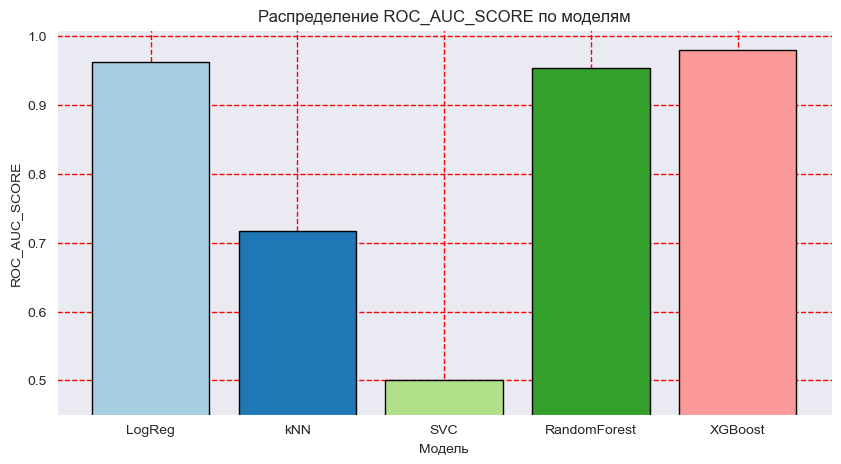

In [9]:
models_names = ['LogReg', 'kNN', 'SVC', 'RandomForest', 'XGBoost']
ut.plot_metrics_hist(models_names, metrics)

In [10]:
best_metric = max(metrics)
best_model_name = models_names[metrics.index(best_metric)]
best_model = fitted_models[metrics.index(best_metric)]

print('Best Model:', best_model_name)
print('Best Metric, ROC_AUC_SCORE:', round(best_metric, 4))
print(classification_report(y_true=y_test, y_pred=best_model.predict(X_test.values)))

Best Model: XGBoost
Best Metric, ROC_AUC_SCORE: 0.9802
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       759
           1       0.98      0.96      0.97       135

    accuracy                           0.99       894
   macro avg       0.99      0.98      0.98       894
weighted avg       0.99      0.99      0.99       894



In [11]:
import joblib

# Сохранение модели в файл
filename = f'../ML/models/{best_model_name}.pkl'
joblib.dump(best_model, filename)

['../ML/models/XGBoost.pkl']

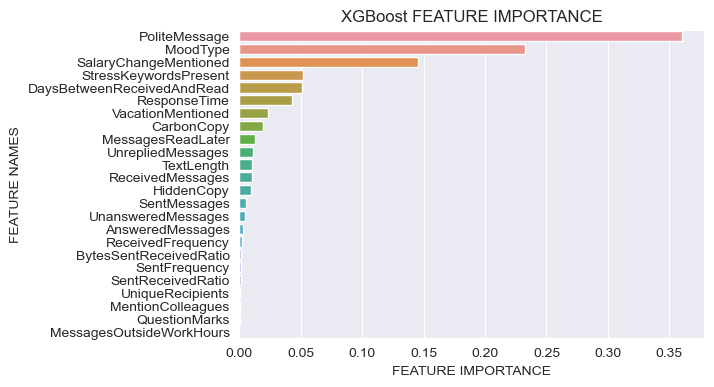

In [12]:
from matplotlib import pyplot as plt

ut.plot_feature_importance(best_model.feature_importances_,X_train.columns, best_model_name)

plt.savefig('../data/img/XGB.png', bbox_inches="tight")

In [13]:
rf = RandomForestClassifier()
rf.fit(eval_data['X_train'], eval_data['y_train'])

# Сохранение модели в файл
filename = f'../ML/models/RandomForest.pkl'
joblib.dump(rf, filename)

C:\Users\S\anaconda3\envs\ds_en\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


['../ML/models/RandomForest.pkl']